#### Clean the data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
file_source = 'https://github.com/gastonstat/CreditScoring/blob/master/CreditScoring.csv?raw=true'
df = pd.read_csv(file_source)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df

status  seniority  home  time  age  marital  records  job  expenses  \
0          1          9     1    60   30        2        1    3        73   
1          1         17     1    60   58        3        1    1        48   
2          2         10     2    36   46        2        2    3        90   
3          1          0     1    60   24        1        1    1        63   
4          1          0     1    36   26        1        1    1        46   
...      ...        ...   ...   ...  ...      ...      ...  ...       ...   
4450       2          1     1    60   39        2        1    1        69   
4451       1         22     2    60   46        2        1    1        60   
4452       2          0     2    24   37        2        1    2        60   
4453       1          0     1    48   23        1        1    3        49   
4454       1          5     2    60   32        2        1    3        60   

      income  assets  debt  amount  price  
0        129       0     0     800    846  
1        131       0     0    1000   1658  
2        200    3000     0    2000   2985  
3        182    2500     0     900   1325  
4        107       0     0     310    910  
...      ...     ...   ...     ...    ...  
4450      92       0     0     900   1020  
4451      75    3000   600     950   1263  
4452      90    3500     0     500    963  
4453     140       0     0     550    550  
4454     140    4000  1000    1350   1650  

[4455 rows x 14 columns]

In [7]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'seperated',
    5: 'divorced',
    6: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

In [8]:
df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

In [9]:
df.head()

status  seniority   home  time  age  marital records        job  expenses  \
0       ok          9   rent    60   30  married      no  freelance        73   
1       ok         17   rent    60   58    widow      no      fixed        48   
2  default         10  owner    36   46  married     yes  freelance        90   
3       ok          0   rent    60   24   single      no      fixed        63   
4       ok          0   rent    36   26   single      no      fixed        46   

   income  assets  debt  amount  price  
0     129       0     0     800    846  
1     131       0     0    1000   1658  
2     200    3000     0    2000   2985  
3     182    2500     0     900   1325  
4     107       0     0     310    910

In [10]:
# replace 99999999 with nan
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [11]:
# remove one unknown from the status column
df[df.status == 'unk']

status  seniority     home  time  age marital records    job  expenses  \
3309    unk         10  private    60   25  single      no  fixed        35   

      income  assets  debt  amount  price  
3309   148.0  3000.0   0.0    1500   1888

In [12]:
df = df.drop(3309)

In [13]:
df = df.reset_index(drop=True)

#### Create the train, test, split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [18]:
del df_test['status']
del df_val['status']
del df_train['status']

#### Decision Trees

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [20]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [21]:
# DictVectorizer turns a list of Python dicts into a numeric matrix.
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [22]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [23]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6685264343319367

In [24]:
from sklearn.tree import export_text # helps inspecting what rules the model learnt

In [25]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



#### Decision Tree Learning Algorithm

Threshold: this is mostly what we are trying to find for variables. What are the thresholds that classify the data with the highest accuracy and purity.

For every feature (column) we have, we can keep splitting if we have a lot of rows left at the end of each iteration. For instance, the following screenshot is about whether bank customers would default or not (paying their debts). After splitting based on their previous records of defaulting or not, if we still have many rows left (and if they are not totally pure) such as 500 records etc, we can keep splitting. This is our stopping criteria.

Misclassification rate: tells us how pure or impure our leaves. We want our leaves to be as pure as possible. Thus, higher misclassification rate --> higher impurity.

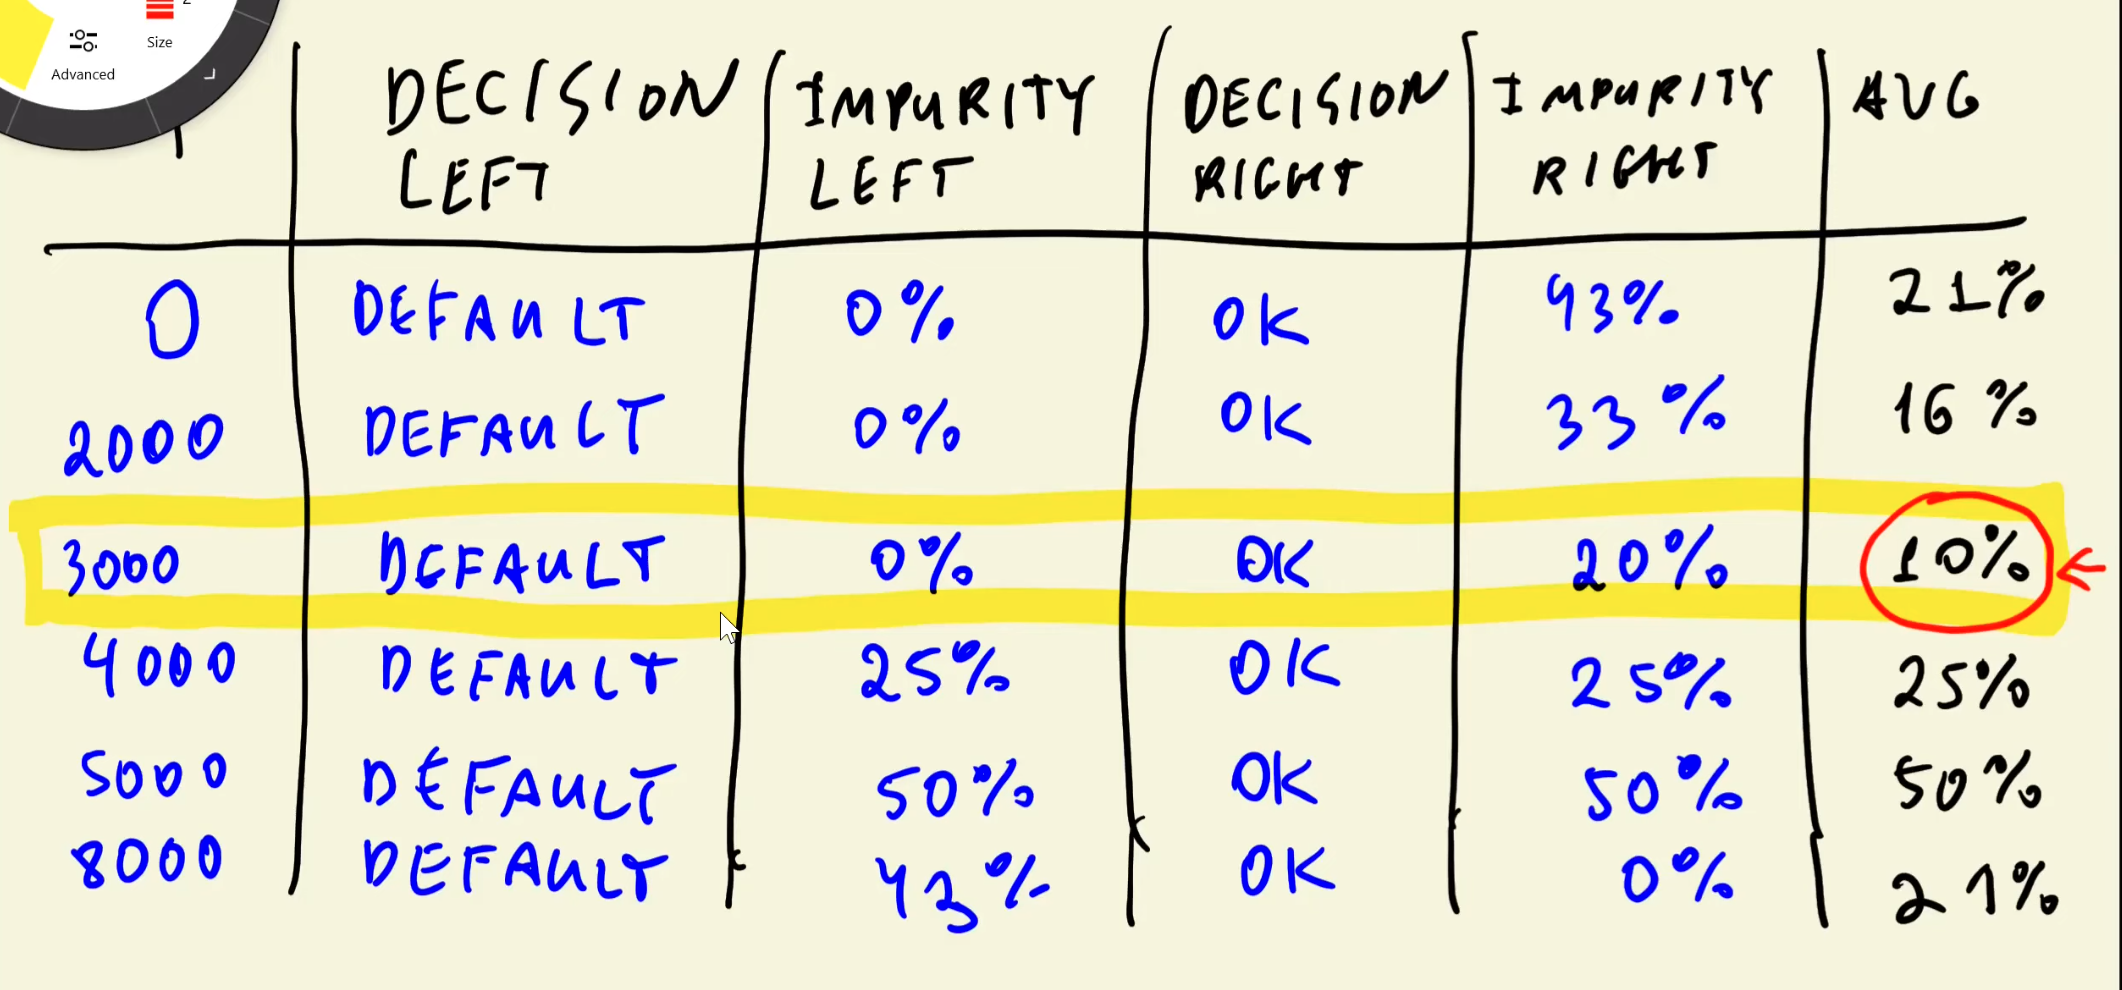

Stopping criteria:
- Group already pure
- Tree reached depth limit
- Group too small to split

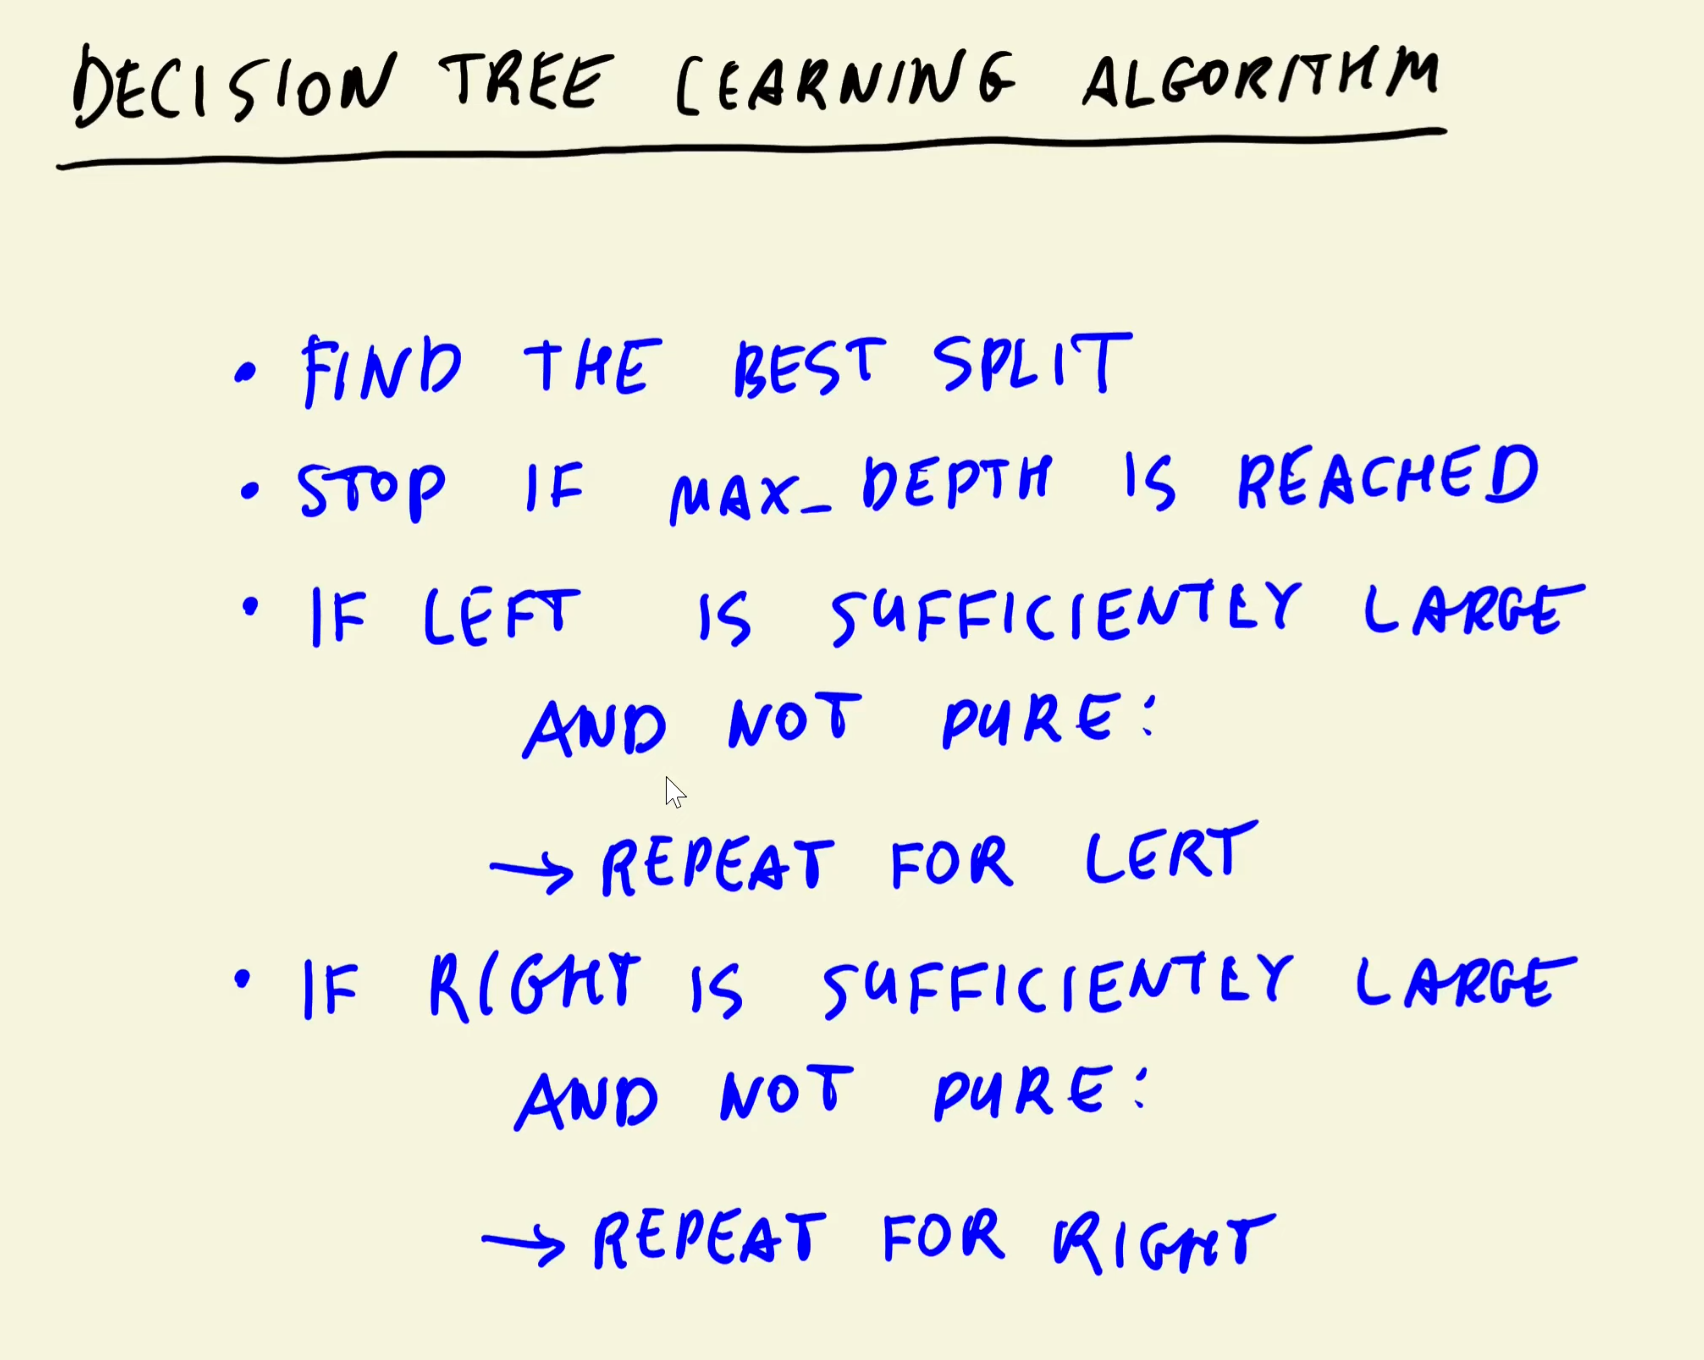

#### Decision trees parameter tuning

Below, try different number of depths for tree depth

In [26]:
for d in [1,2,3,4,5,6,10, 15,20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print(f'D is: {d} and auc is : {round(auc,3)}')

D is: 1 and auc is : 0.606
D is: 2 and auc is : 0.669
D is: 3 and auc is : 0.739
D is: 4 and auc is : 0.761
D is: 5 and auc is : 0.766
D is: 6 and auc is : 0.746
D is: 10 and auc is : 0.695
D is: 15 and auc is : 0.643
D is: 20 and auc is : 0.646
D is: None and auc is : 0.641


In [27]:
scores = []
for d in [4,5,6]:
    for s in [1,2,5,10,15, 20, 100]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d,s,round(auc,3)))

In [28]:
df_scores = pd.DataFrame(scores, columns =['max depth', 'min sample leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

max depth  min sample leaf    auc
18          6               15  0.785
17          6               10  0.778
20          6              100  0.776
12          5               20  0.774
19          6               20  0.774
11          5               15  0.772
9           5                5  0.768
7           5                1  0.767
8           5                2  0.766
4           4               15  0.764
13          5              100  0.763
10          5               10  0.762
16          6                5  0.762
3           4               10  0.761
2           4                5  0.761
1           4                2  0.761
0           4                1  0.761
5           4               20  0.761
14          6                1  0.758
6           4              100  0.756
15          6                2  0.750

In [29]:
df_scores_pivot = df_scores.pivot_table(index='min sample leaf',
                                 columns = ['max depth'], values=['auc'])
df_scores_pivot

auc              
max depth            4      5      6
min sample leaf                     
1                0.761  0.767  0.758
2                0.761  0.766  0.750
5                0.761  0.768  0.762
10               0.761  0.762  0.778
15               0.764  0.772  0.785
20               0.761  0.774  0.774
100              0.756  0.763  0.776

<Axes: xlabel='None-max depth', ylabel='min sample leaf'>

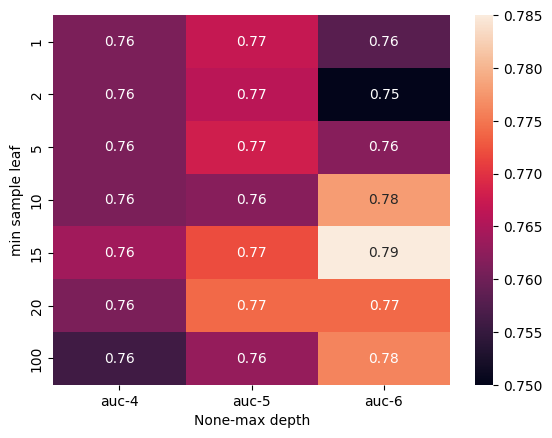

In [30]:
sns.heatmap(df_scores_pivot, annot=True)

In [31]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

#### Emsembles and Random Forests

Random Forest: We take random n features from our dataset to train different models and get their averages to build.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
import matplotlib.pyplot as plt

In [34]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [35]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7866786951151583

In [36]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

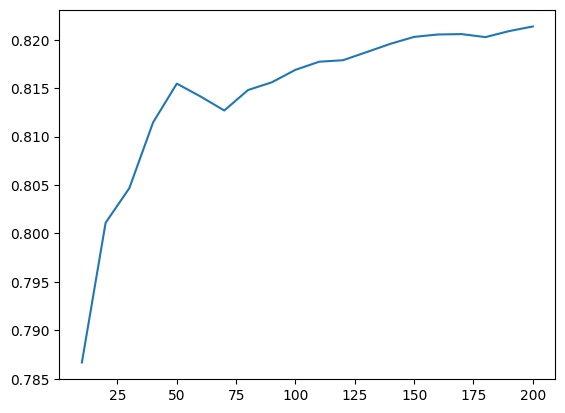

In [37]:
df_scores = pd.DataFrame(scores, columns= ['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

##### Tune parameters of random forest

In [38]:
scores = []
for d in [5,10,15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n , auc))

In [39]:
df_scores = pd.DataFrame(scores, columns= ['max_depth', 'n_estimators', 'auc'])

In [40]:
df_scores.sort_values(by='auc', ascending=False)

max_depth  n_estimators       auc
34         10           150  0.826836
35         10           160  0.826351
33         10           140  0.826212
30         10           110  0.826127
39         10           200  0.825358
..        ...           ...       ...
3           5            40  0.799932
20         10            10  0.799808
4           5            50  0.799735
60         20            10  0.789058
40         15            10  0.783231

[80 rows x 3 columns]

In [41]:
max_depth = 10

Max depth 10 seems to be the best choice. Next, test what is the best min leaf sample.

In [42]:
scores = []
for s in [1, 3, 5,10, 20, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth, 
                                    min_samples_leaf= s,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n , auc))

In [43]:
df_scores = pd.DataFrame(scores, columns= ['min_samples_leaf', 'n_estimators', 'auc'])

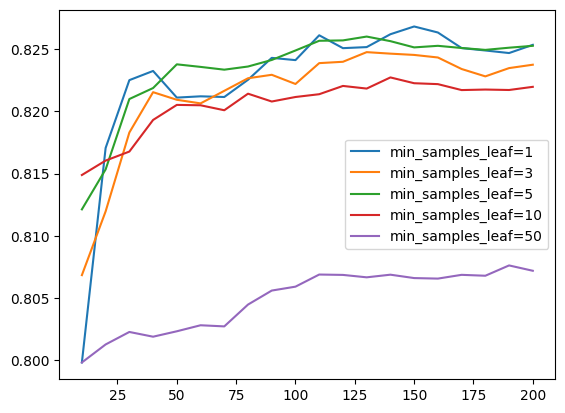

In [44]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf==s]
    plt.plot(df_subset.n_estimators, 
             df_subset.auc,
             label = 'min_samples_leaf=%s' % s            
            )
    
plt.legend()

In [45]:
min_samples_leaf = 5 

In [46]:
# Train the random forest model with the best parameters
rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, min_samples_leaf= min_samples_leaf ,random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=1)

####  Boosting
We train a model on a dataset, the first model makes mistakes. We train a second model that corrects the mistakes of the first model.
This process can be repeated many times and called Boosting.

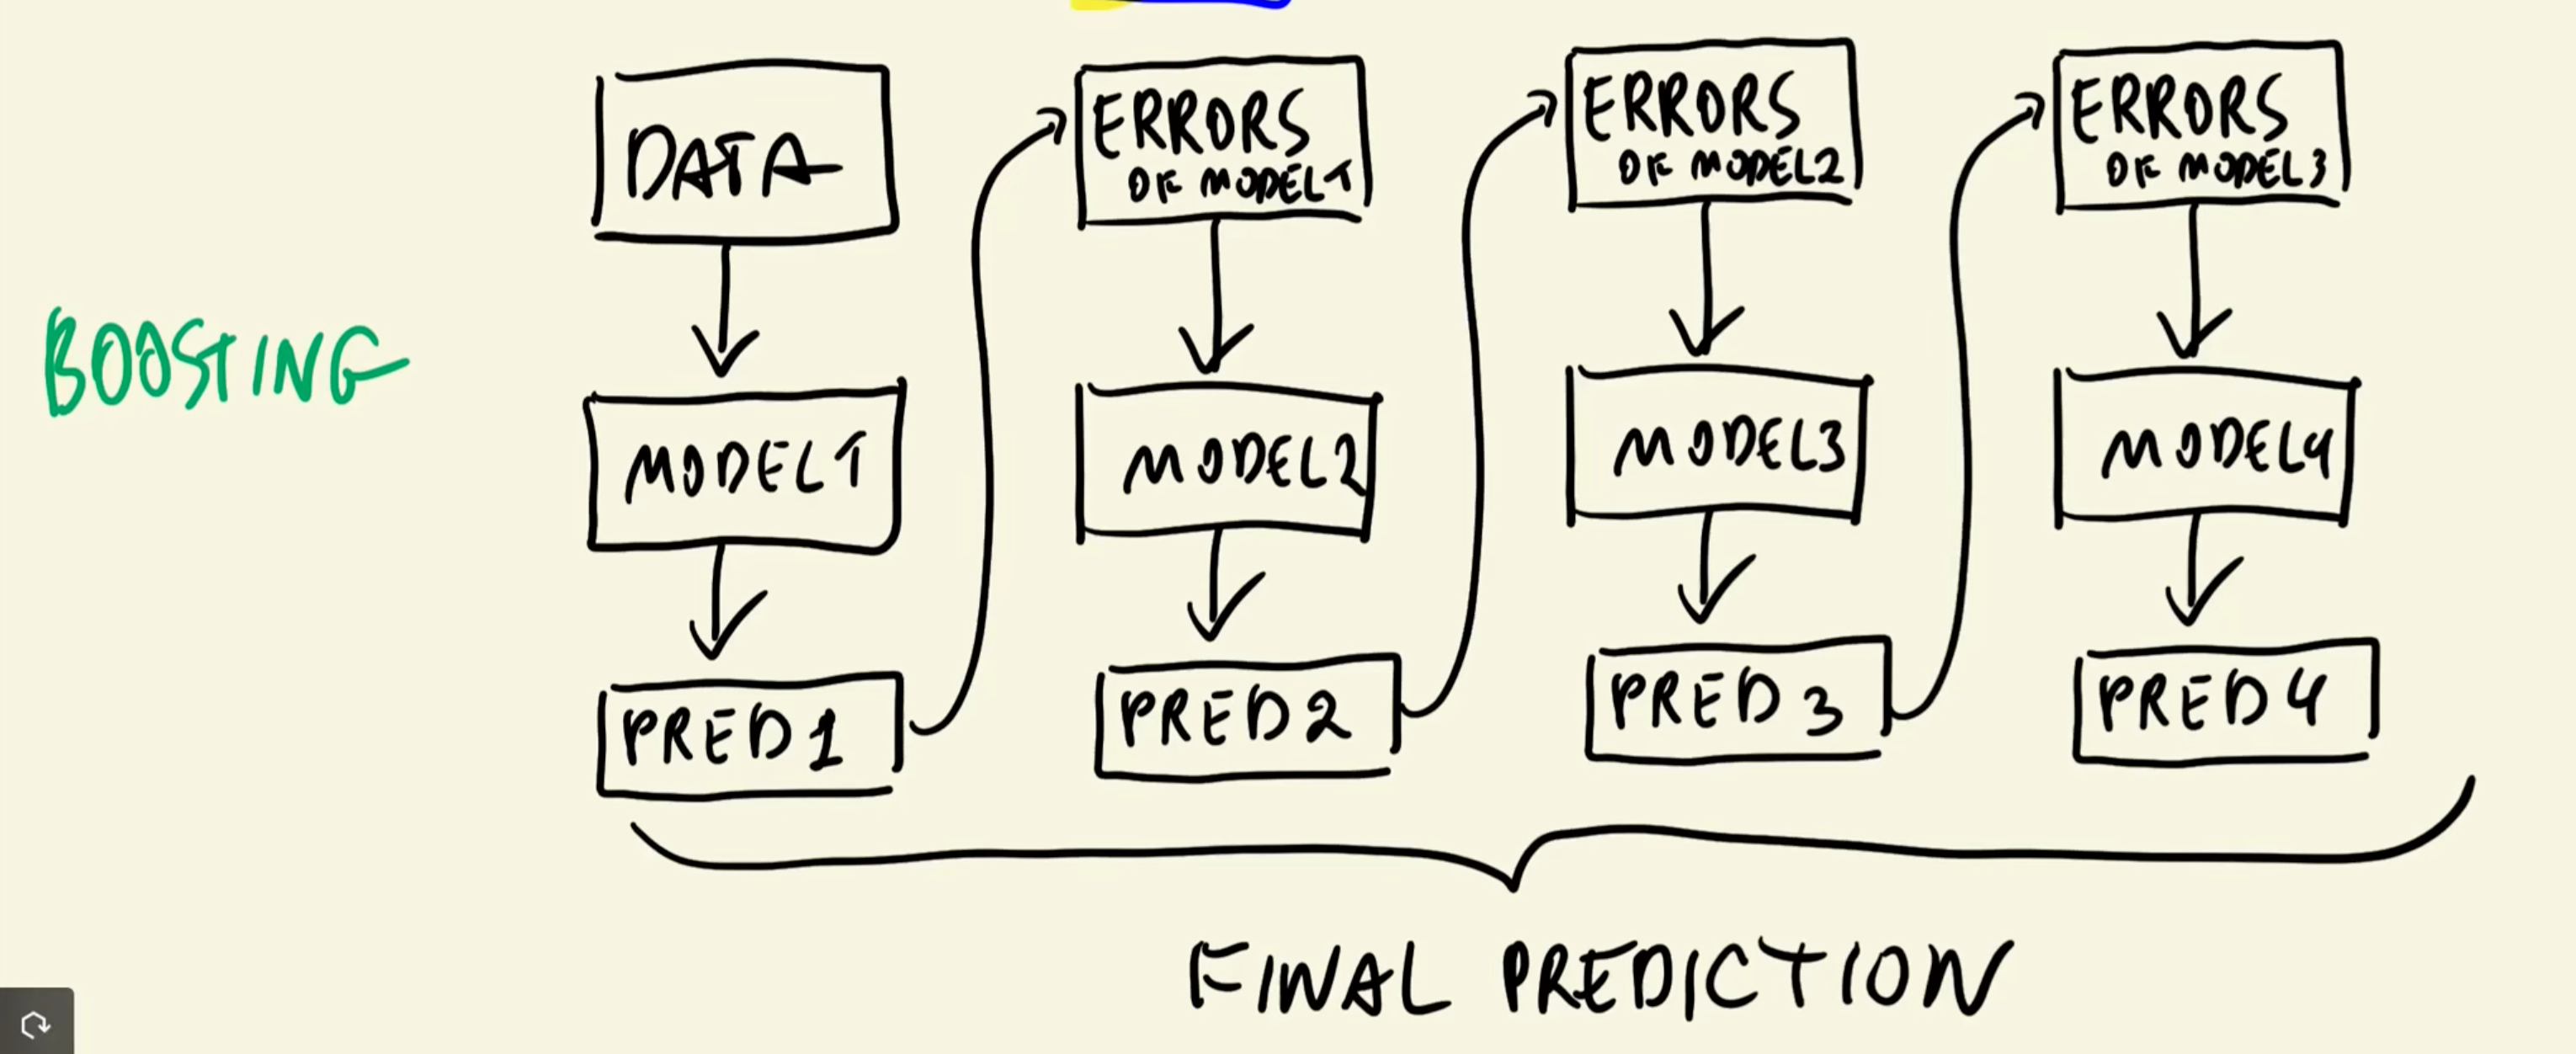

#### Gradient Boosting
If we replace the models with trees as in the Boosting image, we get Gradient Boosting.

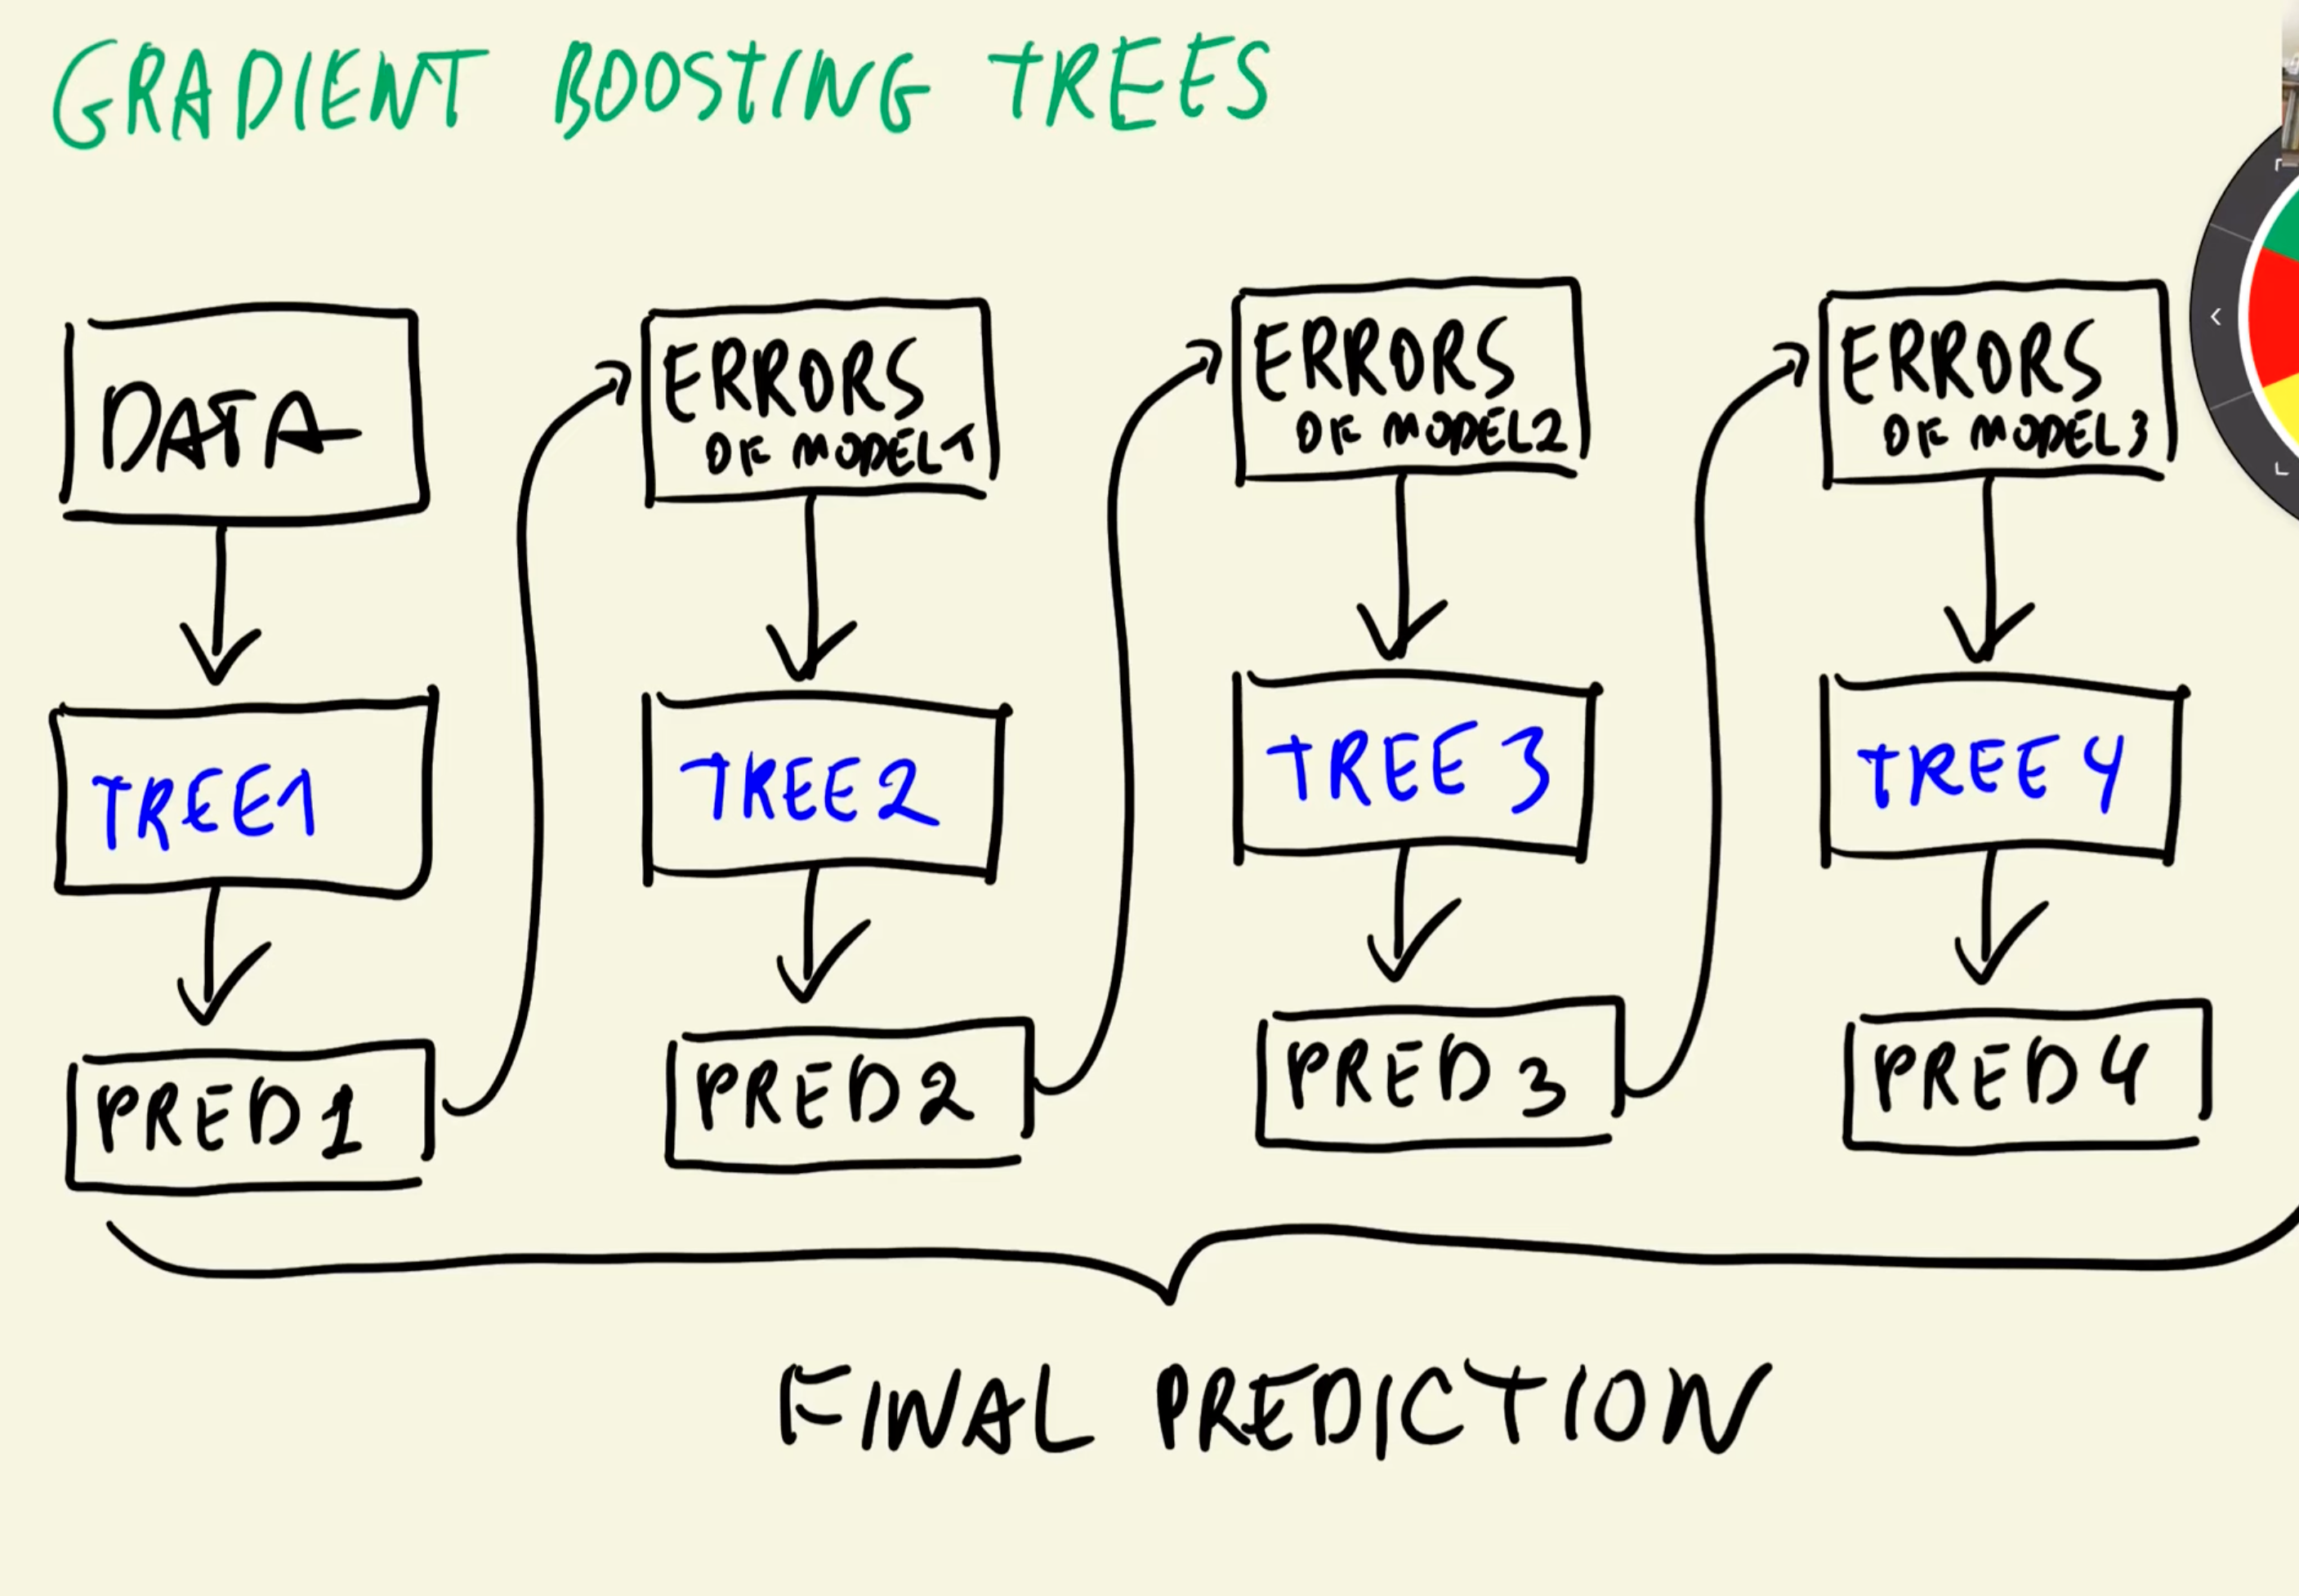 

In [47]:
!pip install xgboost

In [48]:
import xgboost as xgb

In [49]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, y_train, feature_names=list(features))
dval = xgb.DMatrix(X_val, y_val, feature_names=list(features))

In [50]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [51]:
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6, # depth of the trees
    'min_child_weight': 1, # like min sample leaves
    'objective': 'binary:logistic', # objective is classification
    'eval_metric': 'auc', # set eval metric to auc
    'nthread': 4, # how many cores it should to fasten the process
    'seed': 1, 
    'verbosity': 1 # to show the warnings or not
}
evals_results = {}
model = xgb.train(xgb_params, 
                  dtrain,
                  num_boost_round=100, # how many trees to grow
                  verbose_eval=5, # output the evaluation in every 5 training to reduce too much output
                  evals=watchlist, # evaluate the performance while training
                  evals_result=evals_results
                  )

[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.92969	val-auc:0.80822
[10]	train-auc:0.95512	val-auc:0.81115
[15]	train-auc:0.96767	val-auc:0.81993
[20]	train-auc:0.97648	val-auc:0.81877
[25]	train-auc:0.98248	val-auc:0.81520
[30]	train-auc:0.98844	val-auc:0.81613
[35]	train-auc:0.99244	val-auc:0.81453
[40]	train-auc:0.99393	val-auc:0.81407
[45]	train-auc:0.99568	val-auc:0.81392
[50]	train-auc:0.99723	val-auc:0.81276
[55]	train-auc:0.99804	val-auc:0.81299
[60]	train-auc:0.99861	val-auc:0.81244
[65]	train-auc:0.99916	val-auc:0.81197
[70]	train-auc:0.99962	val-auc:0.81243
[75]	train-auc:0.99975	val-auc:0.81152
[80]	train-auc:0.99989	val-auc:0.81359
[85]	train-auc:0.99993	val-auc:0.81193
[90]	train-auc:0.99998	val-auc:0.81038
[95]	train-auc:0.99999	val-auc:0.80871
[99]	train-auc:0.99999	val-auc:0.80838


In [52]:
def format_evals(evals_results):
    train_eval, val_eval = evals_results['train']['auc'], evals_results['val']['auc']
    evaluations = {'train_eval': train_eval, 'val_eval': val_eval}
    df_eval = pd.DataFrame(evaluations)
    return df_eval

In [53]:
train_eval, val_eval = evals_results['train']['auc'], evals_results['val']['auc']

In [54]:
evaluations = {'train_eval': train_eval, 'val_eval': val_eval}

In [55]:
df_eval = pd.DataFrame(evaluations)

In [56]:
df_eval

train_eval  val_eval
0     0.866526  0.779991
1     0.890891  0.790599
2     0.905030  0.788807
3     0.915726  0.799965
4     0.924286  0.803668
..         ...       ...
95    0.999992  0.808714
96    0.999992  0.808690
97    0.999993  0.808557
98    0.999993  0.808176
99    0.999994  0.808375

[100 rows x 2 columns]

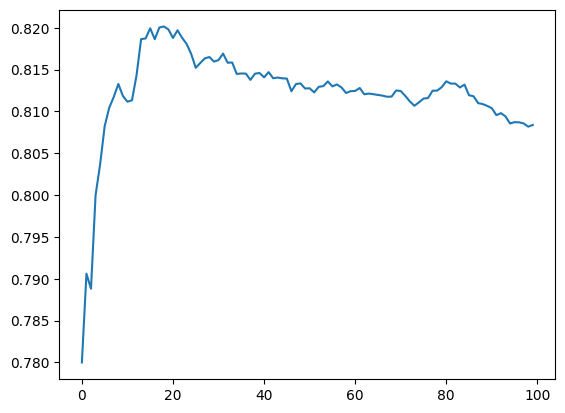

In [57]:
plt.plot(df_eval.index, df_eval.val_eval)

#### XGBoost Parameter Tuning
1. Eta: when we train a second model and use it to correct the mistakes of the first model, eta determines the learning rate,
meaning that how much weight we should assign to the decisions of the second model. Let's say if we give the value 1, then,
all of the decisions of the second model is taken into account. If we give the value 0.3, only 30% of the second model's decision are
taken into account.
2. 

##### Experiment with different etas and plot the results

[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.90462	val-auc:0.79276
[10]	train-auc:0.91936	val-auc:0.80573
[15]	train-auc:0.93128	val-auc:0.81241
[20]	train-auc:0.94007	val-auc:0.81551
[25]	train-auc:0.94698	val-auc:0.81664
[30]	train-auc:0.95175	val-auc:0.81942
[35]	train-auc:0.95668	val-auc:0.82229
[40]	train-auc:0.96125	val-auc:0.82243
[45]	train-auc:0.96437	val-auc:0.82507
[50]	train-auc:0.96869	val-auc:0.82559
[55]	train-auc:0.97260	val-auc:0.82630
[60]	train-auc:0.97493	val-auc:0.82736
[65]	train-auc:0.97720	val-auc:0.82745
[70]	train-auc:0.97937	val-auc:0.82631
[75]	train-auc:0.98202	val-auc:0.82728
[80]	train-auc:0.98397	val-auc:0.82811
[85]	train-auc:0.98547	val-auc:0.82747
[90]	train-auc:0.98770	val-auc:0.82851
[95]	train-auc:0.98899	val-auc:0.82775
[99]	train-auc:0.99011	val-auc:0.82696
[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.92245	val-auc:0.80635
[10]	train-auc:0.94225	val-auc:0.81798
[15]	train-auc:0.95674	val-auc:0.82153
[20]	train-auc:0.96515	val-au

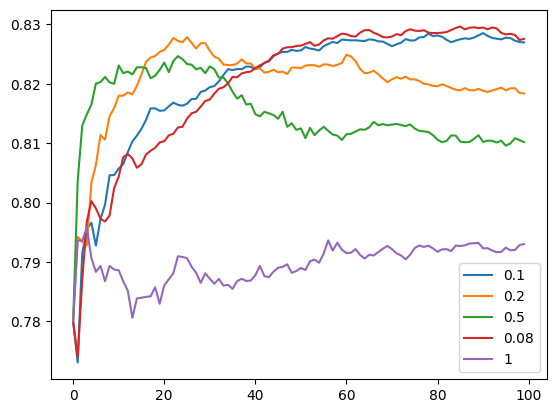

In [58]:
etas = [0.1, 0.2, 0.5, .08, 1]
for e in etas:
    xgb_params['eta'] = e

    evals_results = {}

    model = xgb.train(xgb_params, 
                  dtrain,
                  num_boost_round=100, # how many trees to grow
                  verbose_eval=5, # output the evaluation in every 5 training to reduce too much output
                  evals=watchlist, # evaluate the performance while training
                  evals_result=evals_results
                  )
    df_eval = format_evals(evals_results)
    plt.plot(df_eval.index, df_eval.val_eval, label=e)
    plt.legend()

##### Experiment with different max_depth

[0]	train-auc:0.77610	val-auc:0.73891
[5]	train-auc:0.83058	val-auc:0.77600
[10]	train-auc:0.85036	val-auc:0.79448
[15]	train-auc:0.85993	val-auc:0.80317
[20]	train-auc:0.86898	val-auc:0.80852
[25]	train-auc:0.87768	val-auc:0.81474
[30]	train-auc:0.88186	val-auc:0.81747
[35]	train-auc:0.88619	val-auc:0.81957
[40]	train-auc:0.88961	val-auc:0.82042
[45]	train-auc:0.89281	val-auc:0.82407
[50]	train-auc:0.89673	val-auc:0.82755
[55]	train-auc:0.89964	val-auc:0.82759
[60]	train-auc:0.90252	val-auc:0.82725
[65]	train-auc:0.90552	val-auc:0.82771
[70]	train-auc:0.90859	val-auc:0.82809
[75]	train-auc:0.91031	val-auc:0.82813
[80]	train-auc:0.91216	val-auc:0.82920
[85]	train-auc:0.91443	val-auc:0.83015
[90]	train-auc:0.91623	val-auc:0.83121
[95]	train-auc:0.91794	val-auc:0.83059
[99]	train-auc:0.91889	val-auc:0.83073
[0]	train-auc:0.81665	val-auc:0.76001
[5]	train-auc:0.85305	val-auc:0.79139
[10]	train-auc:0.86699	val-auc:0.80069
[15]	train-auc:0.88030	val-auc:0.80706
[20]	train-auc:0.89074	val-au

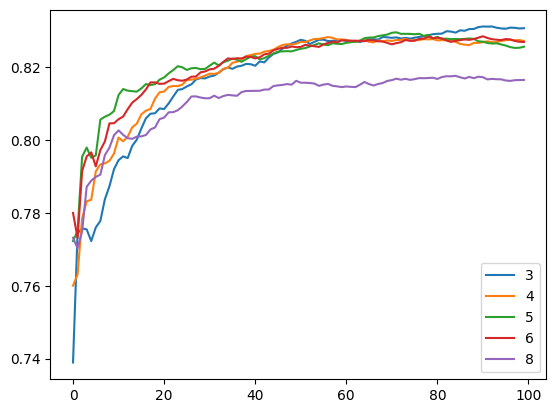

In [59]:
max_depths = [3, 4, 5, 6, 8]
for md in max_depths:
    xgb_params['max_depth'] = md
    xgb_params['eta'] = 0.1

    evals_results = {}

    model = xgb.train(xgb_params, 
                  dtrain,
                  num_boost_round=100, # how many trees to grow
                  verbose_eval=5, # output the evaluation in every 5 training to reduce too much output
                  evals=watchlist, # evaluate the performance while training
                  evals_result=evals_results
                  )
    df_eval = format_evals(evals_results)
    plt.plot(df_eval.index, df_eval.val_eval, label=md)
    plt.legend()

In [60]:
# best values
eta = 0.1
max_depth = 3

##### Experiment with different min_child_weight

[0]	train-auc:0.77610	val-auc:0.73891
[5]	train-auc:0.83058	val-auc:0.77600
[10]	train-auc:0.85036	val-auc:0.79448
[15]	train-auc:0.85993	val-auc:0.80317
[20]	train-auc:0.86898	val-auc:0.80852
[25]	train-auc:0.87768	val-auc:0.81474
[30]	train-auc:0.88186	val-auc:0.81747
[35]	train-auc:0.88619	val-auc:0.81957
[40]	train-auc:0.88961	val-auc:0.82042
[45]	train-auc:0.89281	val-auc:0.82407
[50]	train-auc:0.89673	val-auc:0.82755
[55]	train-auc:0.89964	val-auc:0.82759
[60]	train-auc:0.90252	val-auc:0.82725
[65]	train-auc:0.90552	val-auc:0.82771
[70]	train-auc:0.90859	val-auc:0.82809
[75]	train-auc:0.91031	val-auc:0.82813
[80]	train-auc:0.91216	val-auc:0.82920
[85]	train-auc:0.91443	val-auc:0.83015
[90]	train-auc:0.91623	val-auc:0.83121
[95]	train-auc:0.91794	val-auc:0.83059
[99]	train-auc:0.91889	val-auc:0.83073
[0]	train-auc:0.77424	val-auc:0.73571
[5]	train-auc:0.82956	val-auc:0.77280
[10]	train-auc:0.84624	val-auc:0.78625
[15]	train-auc:0.85994	val-auc:0.80524
[20]	train-auc:0.86708	val-au

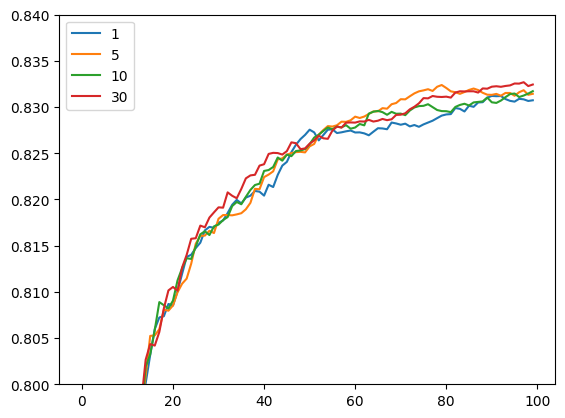

In [63]:
min_child_weights = [1, 5, 10, 30]
for mc in min_child_weights:
    xgb_params['max_depth'] = max_depth
    xgb_params['eta'] = eta
    xgb_params['min_child_weight'] = mc
    evals_results = {}

    model = xgb.train(xgb_params, 
                  dtrain,
                  num_boost_round=100, # how many trees to grow
                  verbose_eval=5, # output the evaluation in every 5 training to reduce too much output
                  evals=watchlist, # evaluate the performance while training
                  evals_result=evals_results
                  )
    df_eval = format_evals(evals_results)
    plt.plot(df_eval.index, df_eval.val_eval, label=mc)
    plt.ylim(0.80, 0.84)
    plt.legend()

##### Final Model

In [ ]:
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3, # depth of the trees
    'min_child_weight': 5, # like min sample leaves
    'objective': 'binary:logistic', # objective is classification
    'eval_metric': 'auc', # set eval metric to auc
    'nthread': 4, # how many cores it should to fasten the process
    'seed': 1, 
    'verbosity': 1 # to show the warnings or not
}
evals_results = {}
model = xgb.train(xgb_params, 
                  dtrain,
                  num_boost_round=175, # how many trees to grow
                  verbose_eval=5, # output the evaluation in every 5 training to reduce too much output
                  evals=watchlist, # evaluate the performance while training
                  evals_result=evals_results
                  )

Other parameters:
- colsample_bytree: how many features each tree should have. Default is 1 (all features)
- subsample: how many rows each tree should see. E.g. each tree gets randomly selected 0.8 of the training data.

#### Selecting the best model

Decision Tree

In [65]:
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7856948245380349

Random Forest

In [67]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf= 5 ,random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8249043375069627

XGBoost

In [69]:
xgb_params = {
    'eta': 0.1, # learning rate
    'max_depth': 3, # depth of the trees
    'min_child_weight': 5, # like min sample leaves
    'objective': 'binary:logistic', # objective is classification
    'eval_metric': 'auc', # set eval metric to auc
    'nthread': 4, # how many cores it should to fasten the process
    'seed': 1, 
    'verbosity': 1 # to show the warnings or not
}
evals_results = {}
model = xgb.train(xgb_params, 
                  dtrain,
                  num_boost_round=175, # how many trees to grow
                  verbose_eval=5, # output the evaluation in every 5 training to reduce too much output
                  evals=watchlist, # evaluate the performance while training
                  evals_result=evals_results
                  )
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

[0]	train-auc:0.77424	val-auc:0.73571
[5]	train-auc:0.82956	val-auc:0.77280
[10]	train-auc:0.84624	val-auc:0.78625
[15]	train-auc:0.85994	val-auc:0.80524
[20]	train-auc:0.86708	val-auc:0.80853
[25]	train-auc:0.87491	val-auc:0.81522
[30]	train-auc:0.88032	val-auc:0.81791
[35]	train-auc:0.88505	val-auc:0.81851
[40]	train-auc:0.88875	val-auc:0.82242
[45]	train-auc:0.89128	val-auc:0.82485
[50]	train-auc:0.89347	val-auc:0.82575
[55]	train-auc:0.89604	val-auc:0.82789
[60]	train-auc:0.89806	val-auc:0.82896
[65]	train-auc:0.90011	val-auc:0.82954
[70]	train-auc:0.90276	val-auc:0.83085
[75]	train-auc:0.90563	val-auc:0.83181
[80]	train-auc:0.90749	val-auc:0.83207
[85]	train-auc:0.90940	val-auc:0.83186
[90]	train-auc:0.91048	val-auc:0.83132
[95]	train-auc:0.91175	val-auc:0.83123
[100]	train-auc:0.91264	val-auc:0.83170
[105]	train-auc:0.91404	val-auc:0.83187
[110]	train-auc:0.91502	val-auc:0.83192
[115]	train-auc:0.91644	val-auc:0.83258
[120]	train-auc:0.91767	val-auc:0.83258
[125]	train-auc:0.9189

0.8323635901285994

#### Train on full dataset and test on test dataset

Flow:
1. Get the train + val dataset as combined.

In [72]:
df_full_train

status  seniority     home  time  age  marital records        job  \
3668       ok         22    owner    48   48  married      no      fixed   
2540  default          8    other    60   41  married      no  freelance   
279        ok          2  parents    36   19  married      no      fixed   
3536       ok          1    owner    12   61  married      no     others   
3866       ok         13    owner    60   27  married      no      fixed   
...       ...        ...      ...   ...  ...      ...     ...        ...   
332   default          4    owner    60   47  married      no  freelance   
1293       ok          2     rent    60   28   single      no      fixed   
4023       ok          2  parents    36   25   single      no      fixed   
3775       ok          4    other    60   25   single      no      fixed   
1945  default          1  parents    48   25   single      no  freelance   

      expenses  income   assets   debt  amount  price  
3668        60   110.0   3000.0    0.0    1000   1460  
2540        45    62.0      0.0    0.0    1800   2101  
279         35   162.0   4000.0  100.0     400    570  
3536        45   103.0  20000.0    0.0     300    650  
3866        35   253.0   7000.0    0.0    1060   1750  
...        ...     ...      ...    ...     ...    ...  
332         75     0.0  13500.0    0.0    1900   1976  
1293        45   101.0      0.0    0.0    1300   1333  
4023        35   110.0      0.0    0.0     500   1200  
3775        35   162.0      0.0    0.0    1800   2999  
1945        35     0.0      0.0    0.0    1800   1809  

[3563 rows x 14 columns]

2. Convert the target variable to int

In [75]:
df_full_train['status'] =  (df_full_train.status == 'default').astype('int').values

3. seperate the target variable from the full dataset.

In [77]:
y_full_train = df_full_train['status'].values

4. delete the target variable just in case to not to feed the model.

In [79]:
del df_full_train['status']

5. convert the full training set to dictionary.

In [81]:
full_train_dicts = df_full_train.to_dict(orient='records')

6. create the dictionary vectorizer object
7. transform the dictionary version of the full training dataset to vector

In [82]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

8. get the test dataset and handle the NaN values.
9. transform the dataset to vector

In [87]:
test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

10. get the feature names
11. convert the full training dataset to xgb's DMatrix format for training.
12. convert the test dataset to xgb's DMatrix format

In [88]:
features = dv.get_feature_names_out()
full_dtrain = xgb.DMatrix(X_full_train, y_full_train, feature_names=list(features))
dtest = xgb.DMatrix(X_test, y_test, feature_names=list(features))

13. create a dictionary of parameters to pass into the training.
14. train the model
15. get the predictions
16. calculate the auc score

In [90]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3, 
    'min_child_weight': 5, 
    'objective': 'binary:logistic', 
    'eval_metric': 'auc', 
    'nthread': 4, 
    'seed': 1, 
    'verbosity': 1
}

model = xgb.train(xgb_params, 
                  full_dtrain,
                  num_boost_round=175
                  )
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8313315575973803